In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# NLP Libraries
import nltk
import spacy
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix)
from xgboost import XGBClassifier

# Transformer Libraries
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Saving Models
import joblib
import pickle

In [60]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\manth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\manth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\manth\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [61]:
# Load spaCy model
try:
    nlp = spacy.load('en_core_web_sm')
except:
    print("Please install spacy model: python -m spacy download en_core_web_sm")

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully!")


Please install spacy model: python -m spacy download en_core_web_sm
All libraries imported successfully!


In [62]:
# Load dataset
df = pd.read_csv('UpdatedResumeDataSet.csv')

print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData Types:")
print(df.dtypes)
print(f"\nMissing Values:")
print(df.isnull().sum())
print(f"\nUnique Categories: {df['Category'].nunique()}")
print(f"\nCategory Distribution:")
print(df['Category'].value_counts())

DATASET OVERVIEW
Dataset Shape: (962, 2)

Columns: ['Category', 'Resume']

First few rows:
       Category                                             Resume
0  Data Science  Skills * Programming Languages: Python (pandas...
1  Data Science  Education Details \r\nMay 2013 to May 2017 B.E...
2  Data Science  Areas of Interest Deep Learning, Control Syste...
3  Data Science  Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4  Data Science  Education Details \r\n MCA   YMCAUST,  Faridab...

Data Types:
Category    object
Resume      object
dtype: object

Missing Values:
Category    0
Resume      0
dtype: int64

Unique Categories: 25

Category Distribution:
Category
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Sales                        40
Data Science                 40
Mechanical Engineer          40
ETL Deve


EXPLORATORY DATA ANALYSIS


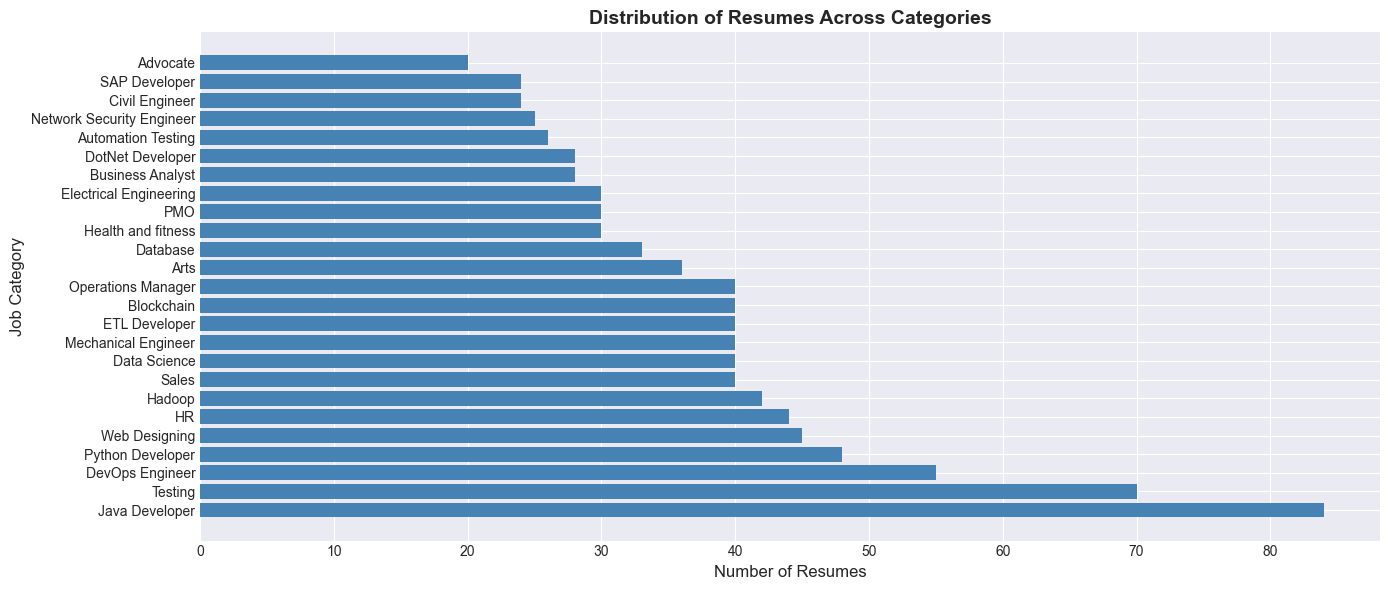

In [63]:
print("\n" + "=" * 80)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# 1. Category Distribution
fig = plt.figure(figsize=(14, 6))
category_counts = df['Category'].value_counts()
plt.barh(category_counts.index, category_counts.values, color='steelblue')
plt.xlabel('Number of Resumes', fontsize=12)
plt.ylabel('Job Category', fontsize=12)
plt.title('Distribution of Resumes Across Categories', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('category_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


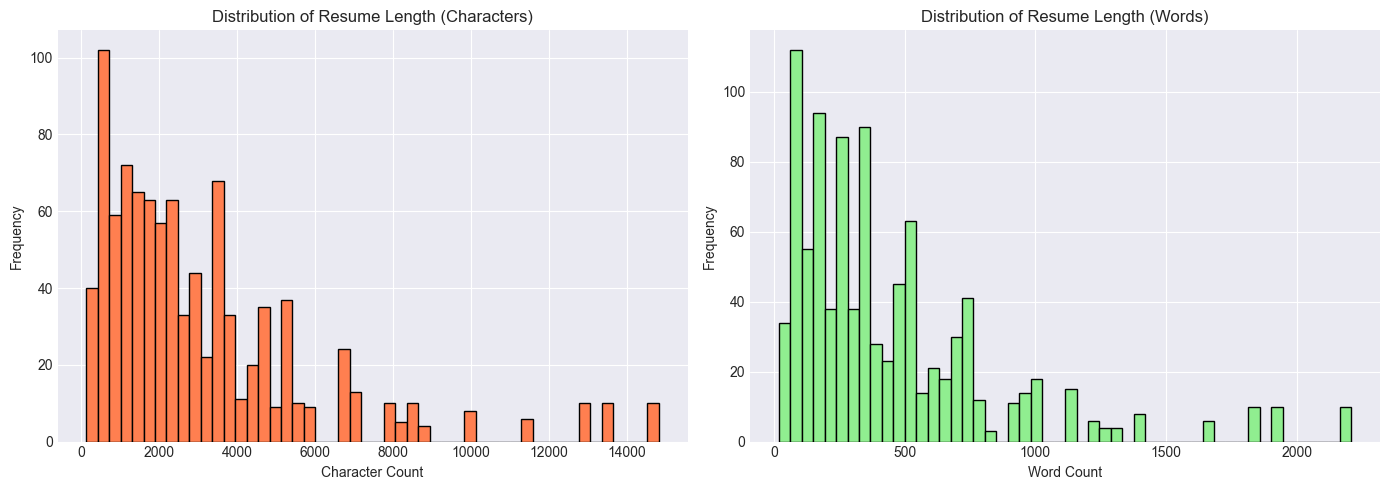


Resume Statistics:
Average Characters: 3160
Average Words: 450
Min Words: 19
Max Words: 2209


In [64]:
# 2. Resume Length Analysis
df['resume_length'] = df['Resume'].apply(lambda x: len(str(x)))
df['word_count'] = df['Resume'].apply(lambda x: len(str(x).split()))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(df['resume_length'], bins=50, color='coral', edgecolor='black')
axes[0].set_xlabel('Character Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Resume Length (Characters)')

axes[1].hist(df['word_count'], bins=50, color='lightgreen', edgecolor='black')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Resume Length (Words)')
plt.tight_layout()
plt.savefig('resume_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nResume Statistics:")
print(f"Average Characters: {df['resume_length'].mean():.0f}")
print(f"Average Words: {df['word_count'].mean():.0f}")
print(f"Min Words: {df['word_count'].min()}")
print(f"Max Words: {df['word_count'].max()}")

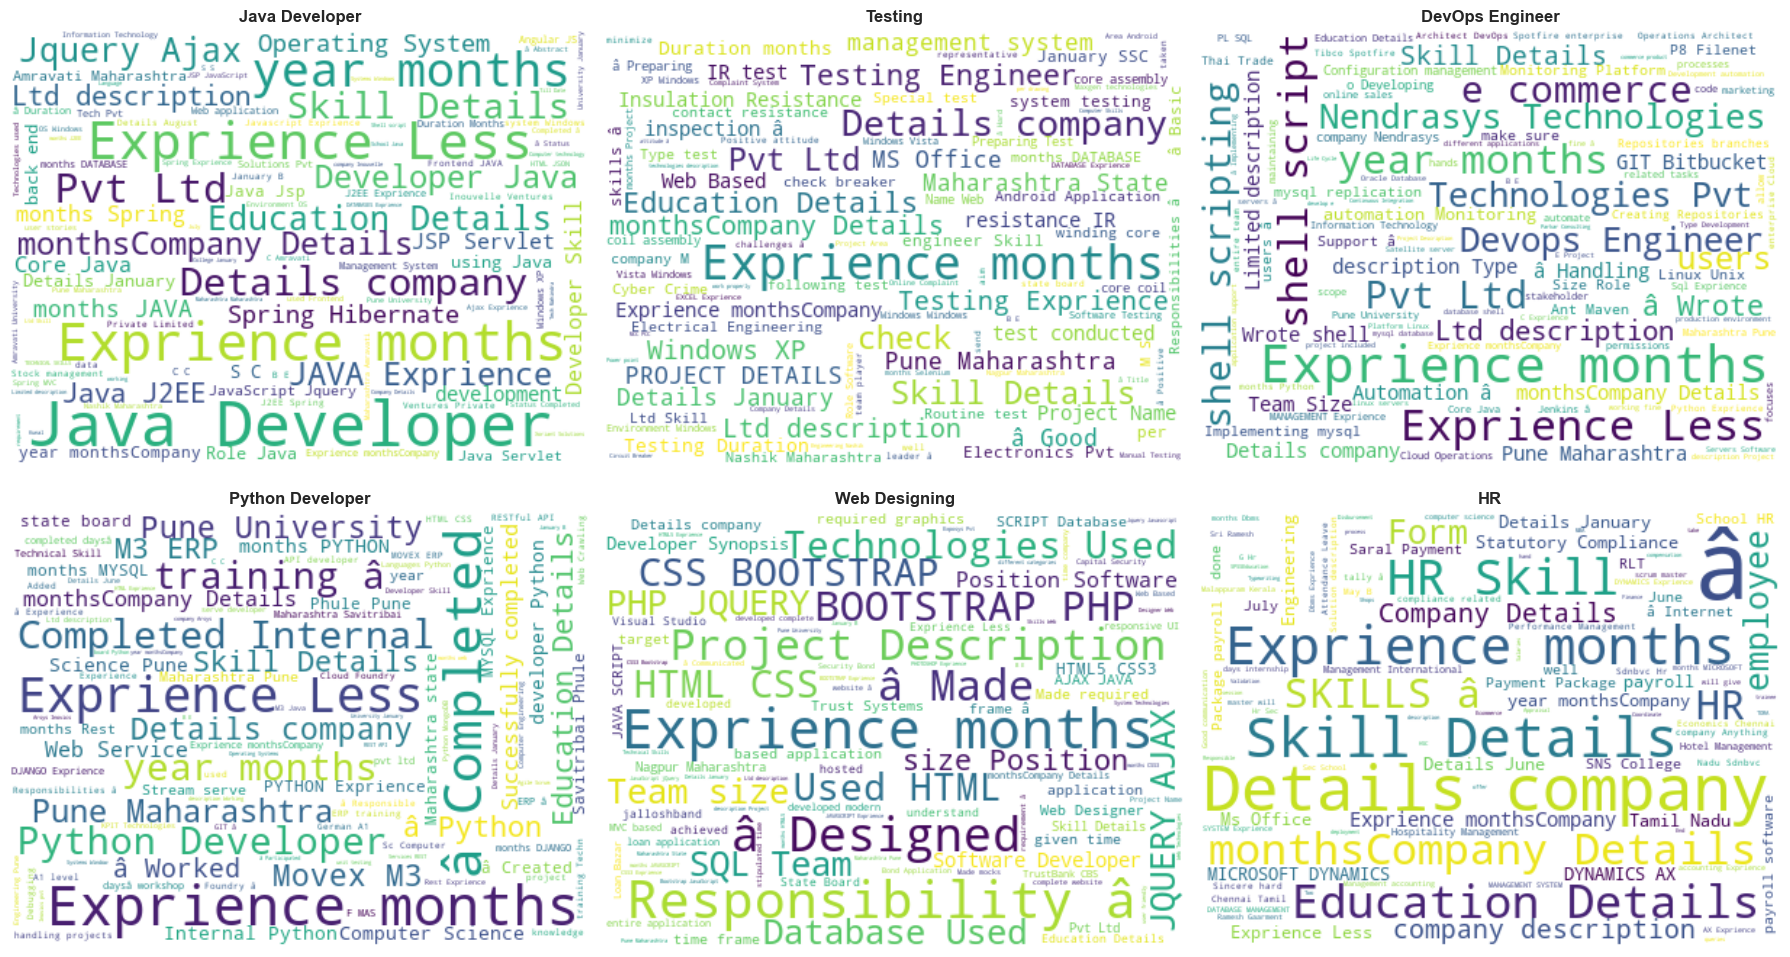

In [65]:
# 3. Word Clouds for Top Categories
top_categories = df['Category'].value_counts().head(6).index

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, category in enumerate(top_categories):
    text = ' '.join(df[df['Category'] == category]['Resume'].astype(str))
    wordcloud = WordCloud(width=400, height=300, background_color='white', 
                          colormap='viridis', max_words=100).generate(text)
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'{category}', fontsize=12, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('wordclouds_by_category.png', dpi=300, bbox_inches='tight')
plt.show()


In [66]:
print("\n" + "=" * 80)
print("TEXT PREPROCESSING")
print("=" * 80)

def clean_resume(text):
    """
    Comprehensive text cleaning function for resumes
    """
    # Convert to string
    text = str(text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove phone numbers
    text = re.sub(r'\b\d{10}\b|\b\d{3}[-.]?\d{3}[-.]?\d{4}\b', '', text)
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def preprocess_text(text):
    """
    Advanced preprocessing with stopword removal and lemmatization
    """
    # Ensure punkt_tab is downloaded
    try:
        nltk.data.find('tokenizers/punkt_tab')
    except LookupError:
        nltk.download('punkt_tab')

    # Clean text
    text = clean_resume(text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

print("Cleaning resumes...")
df['cleaned_resume'] = df['Resume'].apply(clean_resume)
print("Preprocessing resumes (tokenization, stopword removal, lemmatization)...")
df['preprocessed_resume'] = df['Resume'].apply(preprocess_text)

print(f"\Preprocessing complete!")
print(f"\nExample - Original vs Cleaned vs Preprocessed:")
print(f"\nOriginal:\n{df['Resume'].iloc[0][:300]}...")
print(f"\nCleaned:\n{df['cleaned_resume'].iloc[0][:300]}...")
print(f"\nPreprocessed:\n{df['preprocessed_resume'].iloc[0][:300]}...")


TEXT PREPROCESSING
Cleaning resumes...
Preprocessing resumes (tokenization, stopword removal, lemmatization)...
\Preprocessing complete!

Example - Original vs Cleaned vs Preprocessed:

Original:
Skills * Programming Languages: Python (pandas, numpy, scipy, scikit-learn, matplotlib), Sql, Java, JavaScript/JQuery. * Machine learning: Regression, SVM, NaÃ¯ve Bayes, KNN, Random Forest, Decision Trees, Boosting techniques, Cluster Analysis, Word Embedding, Sentiment Analysis, Natural Language pr...

Cleaned:
skills programming languages python pandas numpy scipy scikit learn matplotlib sql java javascript jquery machine learning regression svm na ve bayes knn random forest decision trees boosting techniques cluster analysis word embedding sentiment analysis natural language processing dimensionality red...

Preprocessed:
skill programming language python panda numpy scipy scikit learn matplotlib sql java javascript jquery machine learning regression svm bayes knn random forest decision tr

In [67]:
# FEATURE ENGINEERING

print("\n" + "=" * 80)
print("FEATURE ENGINEERING")
print("=" * 80)

# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['Category'])

# Save label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')
print(f"Label encoder saved!")

# Split data
X = df['preprocessed_resume']
y = df['category_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                      random_state=42, stratify=y)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# 1. TF-IDF Vectorization
print("\n Creating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2), 
                                   min_df=2, max_df=0.9)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Save vectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
print(f" TF-IDF vectorizer saved!")
print(f"TF-IDF shape: {X_train_tfidf.shape}")

# 2. Sentence-BERT Embeddings
print("\n Creating Sentence-BERT embeddings...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Create embeddings (this may take a few minutes)
X_train_sbert = sbert_model.encode(X_train.tolist(), show_progress_bar=True)
X_test_sbert = sbert_model.encode(X_test.tolist(), show_progress_bar=True)

print(f" SBERT embeddings created!")
print(f"SBERT shape: {X_train_sbert.shape}")



FEATURE ENGINEERING
Label encoder saved!

Training set size: 769
Test set size: 193

 Creating TF-IDF features...
 TF-IDF vectorizer saved!
TF-IDF shape: (769, 3000)

 Creating Sentence-BERT embeddings...


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

 SBERT embeddings created!
SBERT shape: (769, 384)


In [68]:
#  MODEL TRAINING AND EVALUATION

results = []

# Function to evaluate model
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    """
    Train and evaluate a model with comprehensive metrics
    """
    print(f"\n🔄 Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"✅ {name} Results:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })
    
    return model, y_pred


In [69]:
# 1. Multinomial Naive Bayes (TF-IDF)
nb_model, nb_pred = evaluate_model('Naive Bayes (TF-IDF)', 
                                    MultinomialNB(), 
                                    X_train_tfidf, X_test_tfidf, 
                                    y_train, y_test)

# 2. Logistic Regression (TF-IDF)
lr_model, lr_pred = evaluate_model('Logistic Regression (TF-IDF)', 
                                    LogisticRegression(max_iter=1000, random_state=42), 
                                    X_train_tfidf, X_test_tfidf, 
                                    y_train, y_test)

# 3. SVM (TF-IDF)
svm_model, svm_pred = evaluate_model('SVM (TF-IDF)', 
                                      SVC(kernel='linear', random_state=42), 
                                      X_train_tfidf, X_test_tfidf, 
                                      y_train, y_test)

# 4. Random Forest (TF-IDF)
rf_model, rf_pred = evaluate_model('Random Forest (TF-IDF)', 
                                    RandomForestClassifier(n_estimators=100, random_state=42), 
                                    X_train_tfidf, X_test_tfidf, 
                                    y_train, y_test)

# 5. XGBoost (TF-IDF)
xgb_model, xgb_pred = evaluate_model('XGBoost (TF-IDF)', 
                                      XGBClassifier(n_estimators=100, random_state=42, 
                                                   eval_metric='mlogloss'), 
                                      X_train_tfidf, X_test_tfidf, 
                                      y_train, y_test)

# 6. Logistic Regression (SBERT)
lr_sbert_model, lr_sbert_pred = evaluate_model('Logistic Regression (SBERT)', 
                                                 LogisticRegression(max_iter=1000, random_state=42), 
                                                 X_train_sbert, X_test_sbert, 
                                                 y_train, y_test)

# 7. Random Forest (SBERT)
rf_sbert_model, rf_sbert_pred = evaluate_model('Random Forest (SBERT)', 
                                                 RandomForestClassifier(n_estimators=100, random_state=42), 
                                                 X_train_sbert, X_test_sbert, 
                                                 y_train, y_test)


🔄 Training Naive Bayes (TF-IDF)...
✅ Naive Bayes (TF-IDF) Results:
   Accuracy:  0.9585
   Precision: 0.9672
   Recall:    0.9585
   F1-Score:  0.9570

🔄 Training Logistic Regression (TF-IDF)...
✅ Logistic Regression (TF-IDF) Results:
   Accuracy:  0.9896
   Precision: 0.9904
   Recall:    0.9896
   F1-Score:  0.9897

🔄 Training SVM (TF-IDF)...
✅ SVM (TF-IDF) Results:
   Accuracy:  0.9948
   Precision: 0.9957
   Recall:    0.9948
   F1-Score:  0.9949

🔄 Training Random Forest (TF-IDF)...
✅ Random Forest (TF-IDF) Results:
   Accuracy:  0.9948
   Precision: 0.9957
   Recall:    0.9948
   F1-Score:  0.9949

🔄 Training XGBoost (TF-IDF)...
✅ XGBoost (TF-IDF) Results:
   Accuracy:  1.0000
   Precision: 1.0000
   Recall:    1.0000
   F1-Score:  1.0000

🔄 Training Logistic Regression (SBERT)...
✅ Logistic Regression (SBERT) Results:
   Accuracy:  0.9378
   Precision: 0.9520
   Recall:    0.9378
   F1-Score:  0.9353

🔄 Training Random Forest (SBERT)...
✅ Random Forest (SBERT) Results:
   Accur

In [70]:
# Save best model 
joblib.dump(xgb_model, 'best_model_tfidf.pkl')
joblib.dump(rf_sbert_model, 'best_model_sbert.pkl')
print(f"\n✅ Best models saved!")


✅ Best models saved!



MODEL COMPARISON

📊 Model Performance Comparison:
                       Model  Accuracy  Precision   Recall  F1-Score
        Naive Bayes (TF-IDF)  0.958549   0.967180 0.958549  0.956996
Logistic Regression (TF-IDF)  0.989637   0.990377 0.989637  0.989713
                SVM (TF-IDF)  0.994819   0.995682 0.994819  0.994931
      Random Forest (TF-IDF)  0.994819   0.995682 0.994819  0.994931
            XGBoost (TF-IDF)  1.000000   1.000000 1.000000  1.000000
 Logistic Regression (SBERT)  0.937824   0.952001 0.937824  0.935300
       Random Forest (SBERT)  0.994819   0.995682 0.994819  0.994931


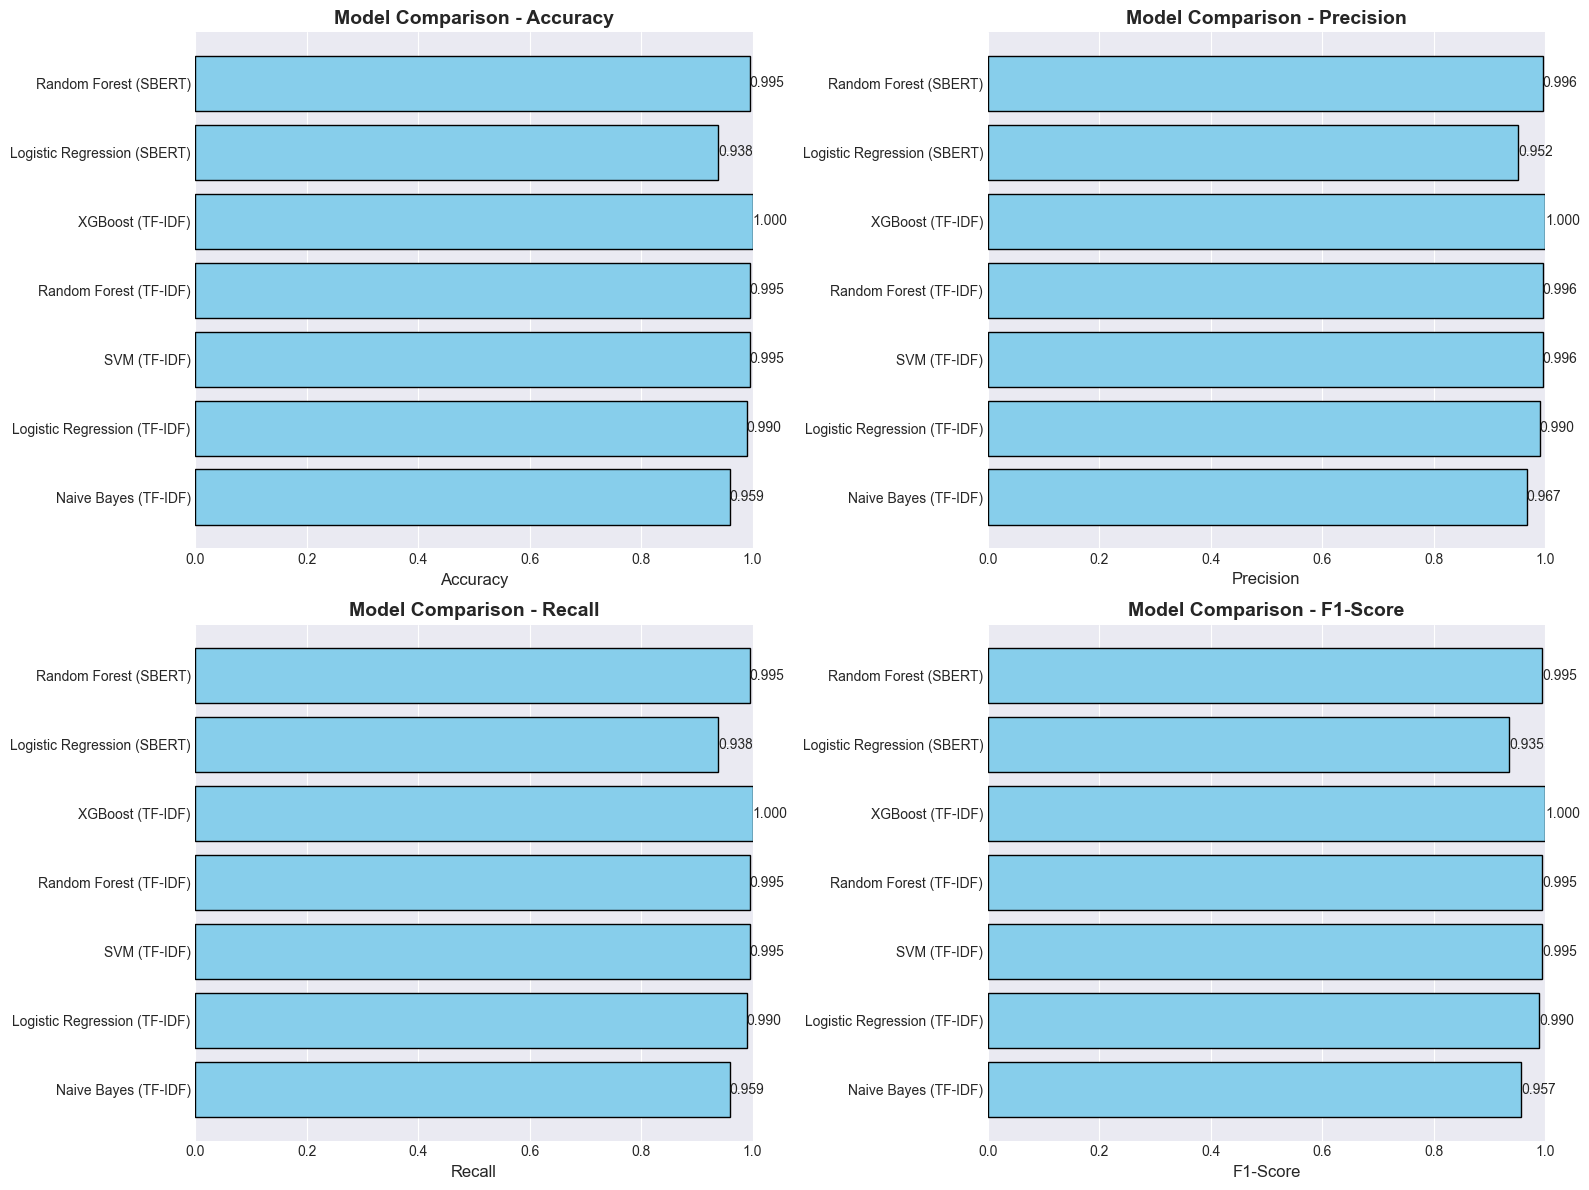

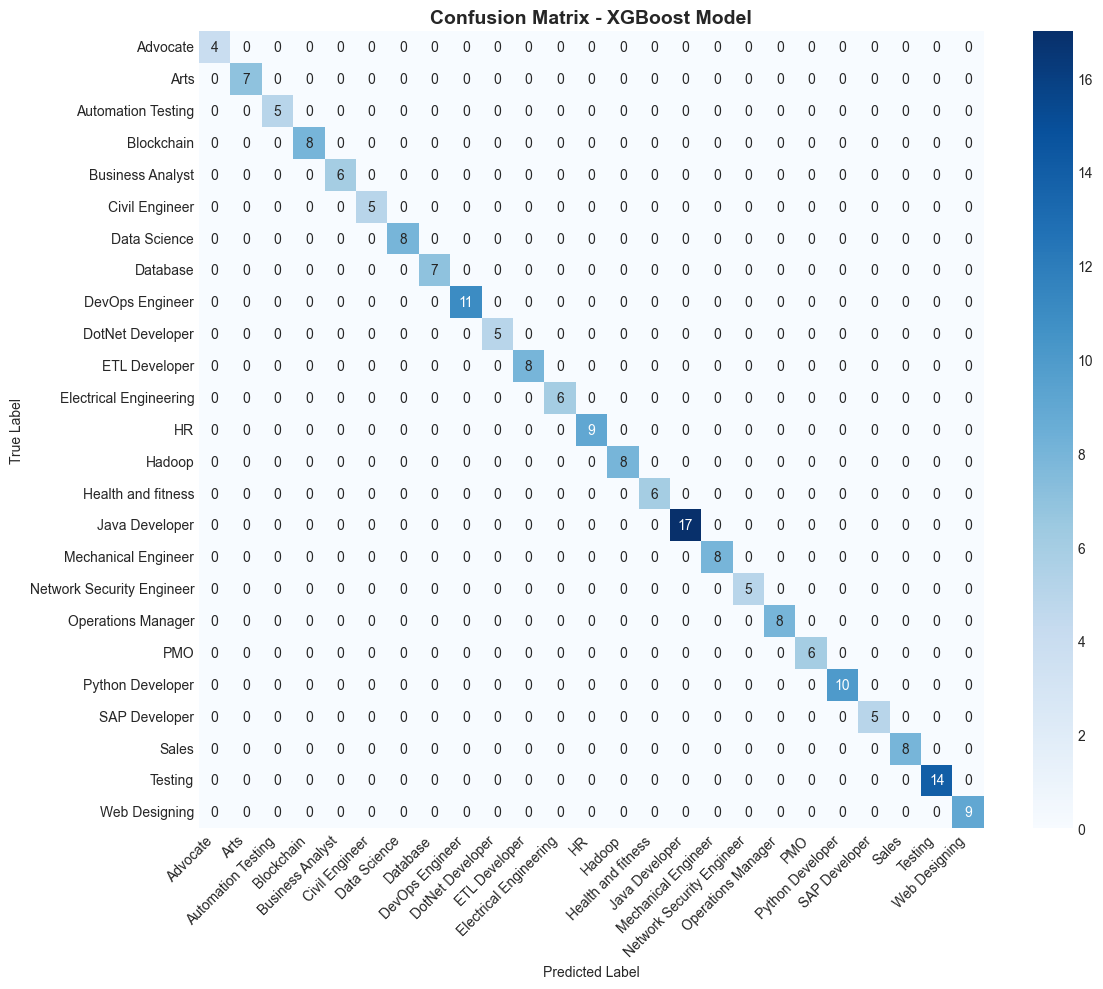


DETAILED CLASSIFICATION REPORT - XGBoost
                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         4
                     Arts       1.00      1.00      1.00         7
       Automation Testing       1.00      1.00      1.00         5
               Blockchain       1.00      1.00      1.00         8
         Business Analyst       1.00      1.00      1.00         6
           Civil Engineer       1.00      1.00      1.00         5
             Data Science       1.00      1.00      1.00         8
                 Database       1.00      1.00      1.00         7
          DevOps Engineer       1.00      1.00      1.00        11
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         8
   Electrical Engineering       1.00      1.00      1.00         6
                       HR       1.00      1.00      1.00         9
                   

In [71]:
# PART 6: MODEL COMPARISON AND VISUALIZATION

print("\n" + "=" * 80)
print("MODEL COMPARISON")
print("=" * 80)

# Create results dataframe
results_df = pd.DataFrame(results)
print("\n📊 Model Performance Comparison:")
print(results_df.to_string(index=False))

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    bars = ax.barh(results_df['Model'], results_df[metric], color='skyblue', edgecolor='black')
    ax.set_xlabel(metric, fontsize=12)
    ax.set_title(f'Model Comparison - {metric}', fontsize=14, fontweight='bold')
    ax.set_xlim([0, 1])
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Confusion Matrix for Best Model (XGBoost)
cm = confusion_matrix(y_test, xgb_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - XGBoost Model', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_xgboost.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification Report
print("\n" + "=" * 80)
print("DETAILED CLASSIFICATION REPORT - XGBoost")
print("=" * 80)
print(classification_report(y_test, xgb_pred, target_names=label_encoder.classes_))


In [72]:
# PART 7: SKILL EXTRACTION

# Comprehensive skill dictionary
SKILLS_DICT = {
    'Programming Languages': ['python', 'java', 'javascript', 'c++', 'c#', 'ruby', 'php', 
                              'swift', 'kotlin', 'go', 'rust', 'scala', 'r'],
    'Web Technologies': ['html', 'css', 'react', 'angular', 'vue', 'nodejs', 'django', 
                         'flask', 'fastapi', 'spring', 'express', 'asp.net'],
    'Data Science & ML': ['machine learning', 'deep learning', 'nlp', 'computer vision', 
                          'tensorflow', 'pytorch', 'keras', 'scikit-learn', 'pandas', 
                          'numpy', 'matplotlib', 'seaborn', 'plotly'],
    'Databases': ['sql', 'mysql', 'postgresql', 'mongodb', 'redis', 'cassandra', 
                  'oracle', 'dynamodb', 'sqlite'],
    'Cloud & DevOps': ['aws', 'azure', 'gcp', 'docker', 'kubernetes', 'jenkins', 
                       'gitlab', 'terraform', 'ansible'],
    'Business Intelligence': ['tableau', 'power bi', 'excel', 'powerpoint', 'looker', 
                              'qlik', 'sap'],
    'Soft Skills': ['communication', 'leadership', 'teamwork', 'problem solving', 
                    'analytical', 'project management']
}

In [73]:
# Flatten skills list
all_skills = []
for category, skills in SKILLS_DICT.items():
    all_skills.extend(skills)

def extract_skills(text):
    """
    Extract skills from resume text
    """
    text = text.lower()
    found_skills = []
    for skill in all_skills:
        if re.search(r'\b' + re.escape(skill) + r'\b', text):
            found_skills.append(skill)
    return found_skills

# Extract skills from all resumes
df['extracted_skills'] = df['cleaned_resume'].apply(extract_skills)
df['skill_count'] = df['extracted_skills'].apply(len)

print(f" Skills extracted from {len(df)} resumes")
print(f"\nAverage skills per resume: {df['skill_count'].mean():.2f}")
print(f"Max skills in a resume: {df['skill_count'].max()}")

 Skills extracted from 962 resumes

Average skills per resume: 3.65
Max skills in a resume: 19



Top 10 Skills by Category:


Data Science:
python              40
machine learning    36
deep learning       20
sql                 20
tableau             16
nlp                 16
java                16
mysql               16
communication       12
html                12

HR:
communication    12
excel             4
leadership        4
r                 4
java              4

Advocate:
Series([], )

Arts:
communication    12

Web Designing:
javascript    36
html          36
css           36
angular       18
java          18
php           18
mysql         18
go             9
sql            9
r              9


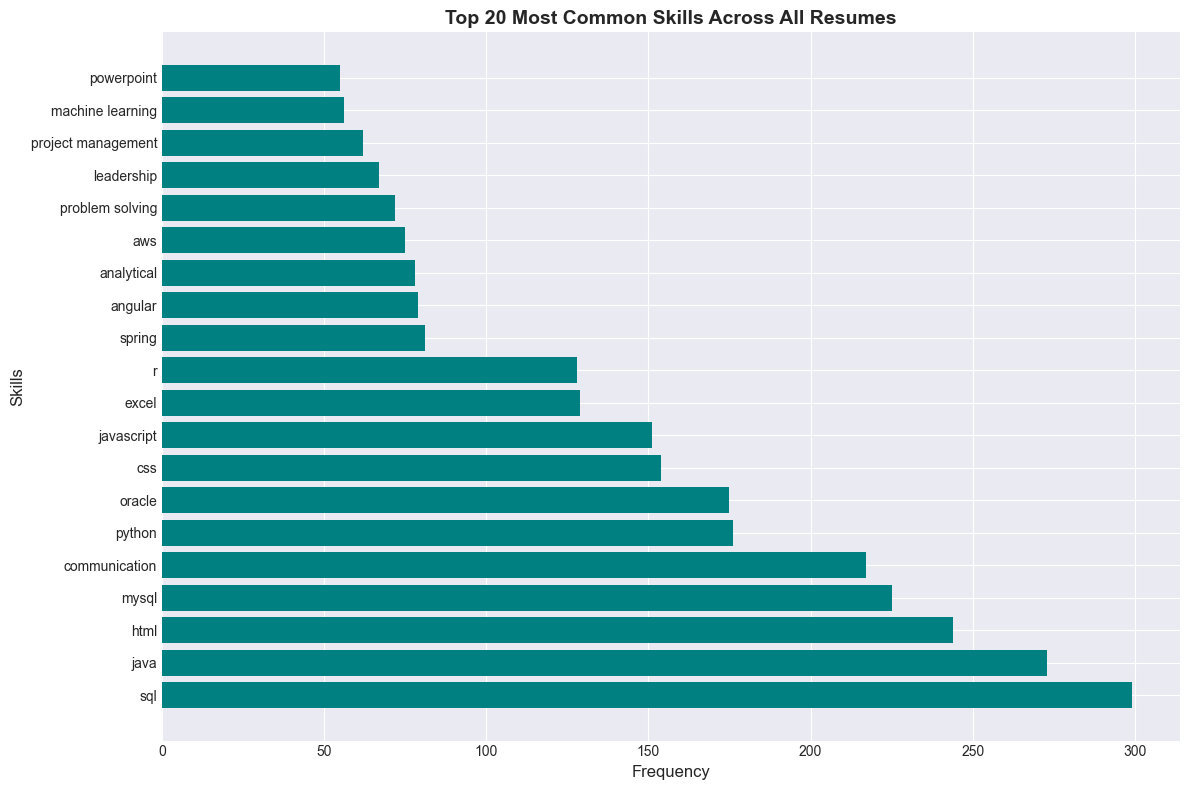

In [74]:
# Top skills by category
print("\nTop 10 Skills by Category:\n")
for category in df['Category'].unique()[:5]:
    category_resumes = df[df['Category'] == category]
    all_category_skills = [skill for skills in category_resumes['extracted_skills'] for skill in skills]
    skill_freq = pd.Series(all_category_skills).value_counts().head(10)
    print(f"\n{category}:")
    print(skill_freq.to_string())

# Visualize top skills overall
all_found_skills = [skill for skills in df['extracted_skills'] for skill in skills]
top_skills = pd.Series(all_found_skills).value_counts().head(20)

plt.figure(figsize=(12, 8))
plt.barh(top_skills.index, top_skills.values, color='teal')
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Skills', fontsize=12)
plt.title('Top 20 Most Common Skills Across All Resumes', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('top_skills_overall.png', dpi=300, bbox_inches='tight')
plt.show()

In [75]:
# PART 8: RESUME-JOB DESCRIPTION MATCHING
# ============================================================================

print("\n" + "=" * 80)
print("RESUME-JOB DESCRIPTION MATCHING")
print("=" * 80)

# Sample Job Description
sample_jd = """
We are looking for an experienced Data Scientist to join our team. 
The ideal candidate should have strong skills in Python, machine learning, 
deep learning, and data visualization. Experience with TensorFlow, PyTorch, 
and cloud platforms like AWS is required. Strong communication and problem-solving 
skills are essential. Knowledge of SQL, pandas, and scikit-learn is a plus.
"""

print("Sample Job Description:")
print(sample_jd)

# Preprocess job description
jd_preprocessed = preprocess_text(sample_jd)
jd_embedding = sbert_model.encode([jd_preprocessed])[0]

# Calculate similarity scores for all resumes
print("\n Calculating similarity scores...")
resume_embeddings = sbert_model.encode(df['preprocessed_resume'].tolist(), 
                                       show_progress_bar=True)
similarity_scores = cosine_similarity([jd_embedding], resume_embeddings)[0]

# Add scores to dataframe
df['jd_match_score'] = similarity_scores
df['jd_match_percentage'] = (similarity_scores * 100).round(2)

# Get top 10 matching resumes
top_matches = df.nlargest(10, 'jd_match_score')[['Category', 'jd_match_percentage', 
                                                   'extracted_skills', 'word_count']]

print("\n Top 10 Matching Resumes for the Job Description:\n")
for idx, (_, row) in enumerate(top_matches.iterrows(), 1):
    print(f"{idx}. Category: {row['Category']}")
    print(f"   Match Score: {row['jd_match_percentage']:.2f}%")
    print(f"   Key Skills: {', '.join(row['extracted_skills'][:8])}")
    print(f"   Resume Length: {row['word_count']} words")
    print()


RESUME-JOB DESCRIPTION MATCHING
Sample Job Description:

We are looking for an experienced Data Scientist to join our team. 
The ideal candidate should have strong skills in Python, machine learning, 
deep learning, and data visualization. Experience with TensorFlow, PyTorch, 
and cloud platforms like AWS is required. Strong communication and problem-solving 
skills are essential. Knowledge of SQL, pandas, and scikit-learn is a plus.


 Calculating similarity scores...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]


 Top 10 Matching Resumes for the Job Description:

1. Category: Data Science
   Match Score: 58.08%
   Key Skills: python, java, machine learning, deep learning, nlp, tensorflow, keras, pandas
   Resume Length: 1153 words

2. Category: Data Science
   Match Score: 58.08%
   Key Skills: python, java, machine learning, deep learning, nlp, tensorflow, keras, pandas
   Resume Length: 1153 words

3. Category: Data Science
   Match Score: 58.08%
   Key Skills: python, java, machine learning, deep learning, nlp, tensorflow, keras, pandas
   Resume Length: 1153 words

4. Category: Data Science
   Match Score: 58.08%
   Key Skills: python, java, machine learning, deep learning, nlp, tensorflow, keras, pandas
   Resume Length: 1153 words

5. Category: Data Science
   Match Score: 58.01%
   Key Skills: python, html, machine learning, excel, powerpoint
   Resume Length: 103 words

6. Category: Data Science
   Match Score: 58.01%
   Key Skills: python, html, machine learning, excel, powerpoint
   

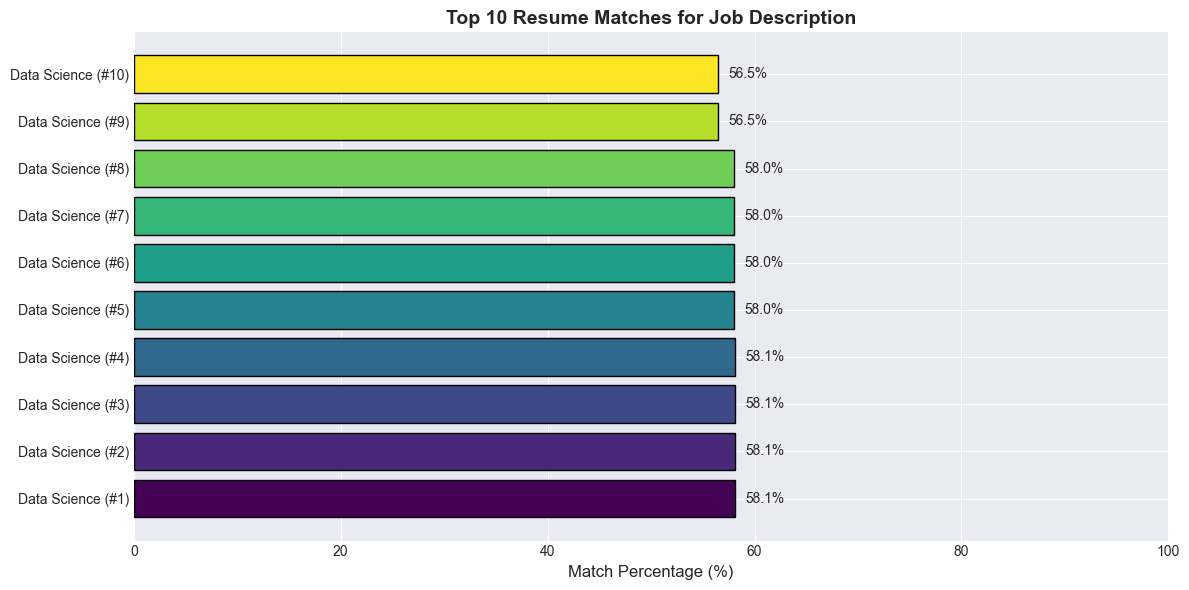


 Skills Required in Job Description: python, machine learning, deep learning, tensorflow, pytorch, scikit-learn, pandas, sql, aws, communication

 Top Candidate Analysis:
   Category: Data Science
   Match Score: 58.08%
   Matched Skills: deep learning, tensorflow, pandas, machine learning, communication, python, sql
   Missing Skills: aws, scikit-learn, pytorch


In [76]:
# Visualize top matches
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(top_matches)))
bars = plt.barh(range(len(top_matches)), top_matches['jd_match_percentage'].values, 
                color=colors, edgecolor='black')
plt.yticks(range(len(top_matches)), 
           [f"{cat} (#{i+1})" for i, cat in enumerate(top_matches['Category'])])
plt.xlabel('Match Percentage (%)', fontsize=12)
plt.title('Top 10 Resume Matches for Job Description', fontsize=14, fontweight='bold')
plt.xlim([0, 100])

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_matches['jd_match_percentage'].values)):
    plt.text(val + 1, bar.get_y() + bar.get_height()/2, 
             f'{val:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('top_resume_matches.png', dpi=300, bbox_inches='tight')
plt.show()

# Skill matching analysis
jd_skills = extract_skills(sample_jd)
print(f"\n Skills Required in Job Description: {', '.join(jd_skills)}")

# For top candidate, show matched vs missing skills
top_candidate = df.nlargest(1, 'jd_match_score').iloc[0]
candidate_skills = set(top_candidate['extracted_skills'])
required_skills = set(jd_skills)
matched_skills = candidate_skills.intersection(required_skills)
missing_skills = required_skills - candidate_skills

print(f"\n Top Candidate Analysis:")
print(f"   Category: {top_candidate['Category']}")
print(f"   Match Score: {top_candidate['jd_match_percentage']:.2f}%")
print(f"   Matched Skills: {', '.join(matched_skills) if matched_skills else 'None'}")
print(f"   Missing Skills: {', '.join(missing_skills) if missing_skills else 'None'}")


In [77]:
# PART 9: SAVE PROCESSED DATA AND MODELS
# ============================================================================

print("\n" + "=" * 80)
print("SAVING MODELS AND DATA")
print("=" * 80)

# Save processed dataframe
df.to_csv('processed_resumes.csv', index=False)
print("Processed data saved to 'processed_resumes.csv'")

# Save SBERT model path (model is already loaded)
with open('sbert_model_name.txt', 'w') as f:
    f.write('all-MiniLM-L6-v2')
print("SBERT model name saved")

# Save skills dictionary
import json
with open('skills_dict.json', 'w') as f:
    json.dump(SKILLS_DICT, f)
print("Skills dictionary saved")


SAVING MODELS AND DATA
Processed data saved to 'processed_resumes.csv'
SBERT model name saved
Skills dictionary saved


In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

# Example training code
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['preprocessed_resume'])

# Save both vectorizer and classifier
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
joblib.dump(svm_model, "best_model_tfidf.pkl")  # Use svm_model or xgb_model as needed


['best_model_tfidf.pkl']

In [83]:
import streamlit as st

# Define the models dictionary using existing objects
models = {
    "tfidf_vectorizer": tfidf_vectorizer,
    "svm_model": svm_model
}

if models.get("tfidf_vectorizer") is not None:
    try:
        if not hasattr(models["tfidf_vectorizer"], "vocabulary_"):
            st.warning("TF-IDF vectorizer is not fitted. Skipping TF-IDF predictions.")
        else:
            X_tfidf = models["tfidf_vectorizer"].transform([pre])
            ...
    except Exception as e:
        st.warning(f"TF-IDF prediction failed: {e}")


2025-10-02 19:15:46.043 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-02 19:15:46.170 
  command:

    streamlit run C:\Users\manth\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-10-02 19:15:46.170 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-02 19:15:46.170 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [84]:
import joblib

tfidf = joblib.load("tfidf_vectorizer.pkl")
print(hasattr(tfidf, "vocabulary_"))  # should be True


True
